# Predicting Toronto Ferry Activity

In [1]:
from Model import Model 
import pandas as pd 

In [2]:
def load_data(file):
    # generic data processing function
    df = pd.read_csv(file,
                dtype={'_id':int, 'Redemption Count': int, 'Sales Count':int},
                parse_dates=['Timestamp'])
    df.sort_values('Timestamp', inplace=True)
    # convert to time-aware
    df.set_index('Timestamp', inplace=True)
    df_daily = df.resample('d').sum()
    # engineer some time features 
    df_daily['monthly'] = df_daily.reset_index().Timestamp.dt.month.values
    df_daily['quarter'] = df_daily.reset_index().Timestamp.dt.quarter.values
    return df_daily

In [3]:
df = load_data('./data/Toronto Island Ferry Ticket Counts.csv')
df.head()

,_id,Redemption Count,Sales Count,monthly,quarter
Timestamp,,,,,
2015-05-01,985694,1,4,5,2
2015-05-02,0,0,0,5,2
2015-05-03,0,0,0,5,2
2015-05-04,4681828,12,75,5,2
2015-05-05,11333457,537,549,5,2


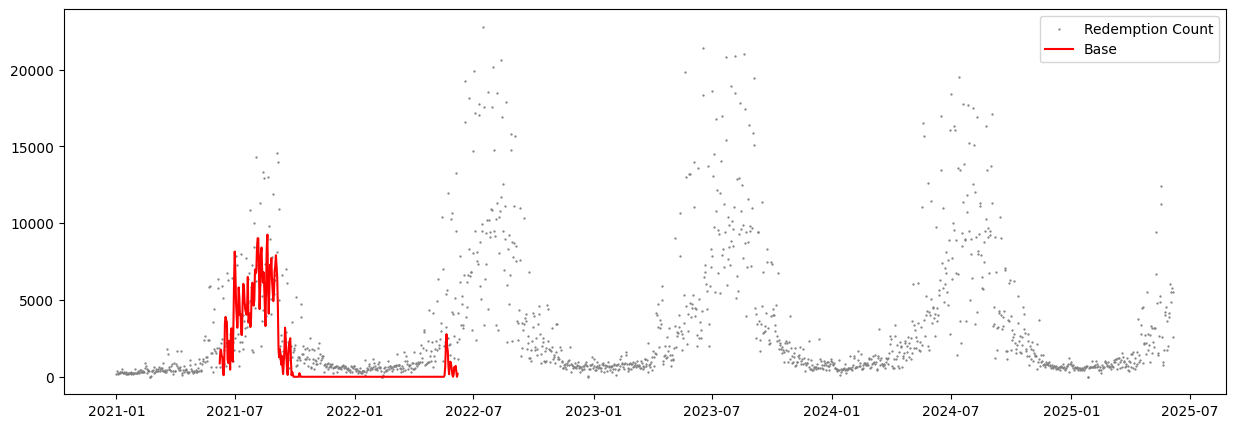

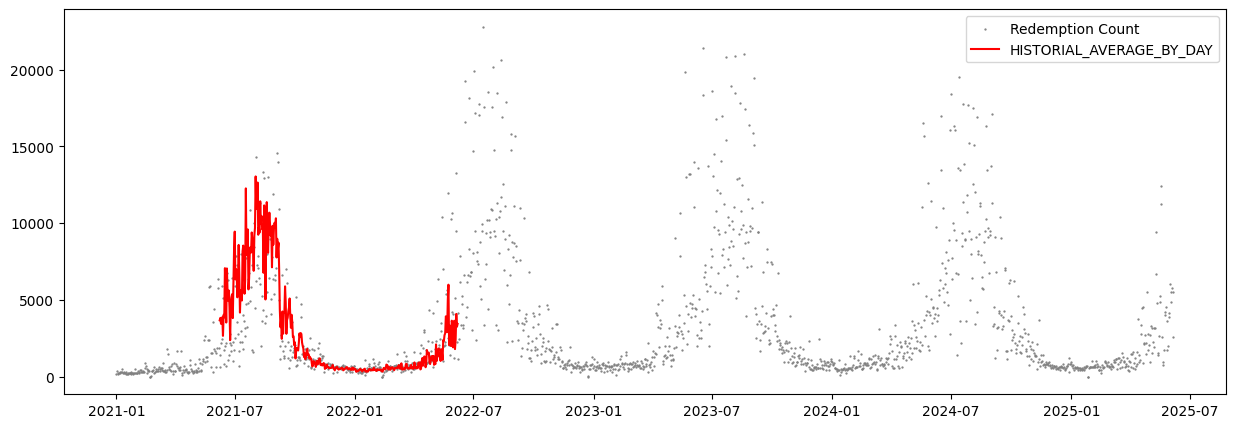

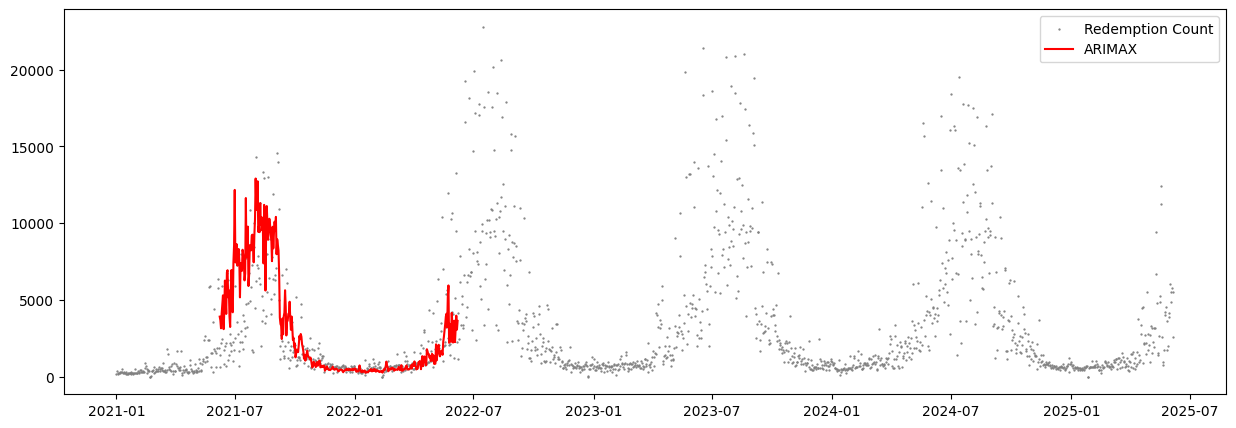

/Users/marianomaisonnave/Repositories/COMP-44081/.venv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


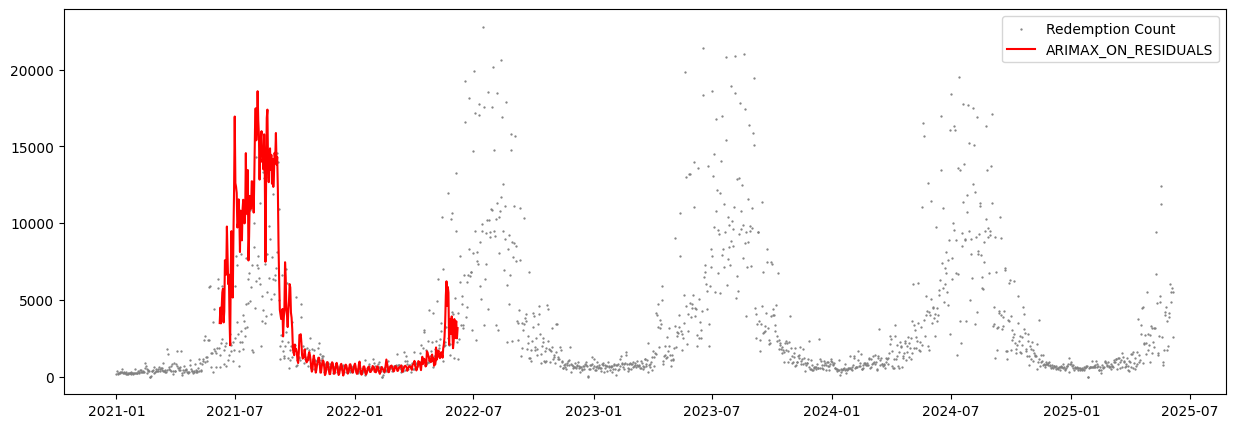

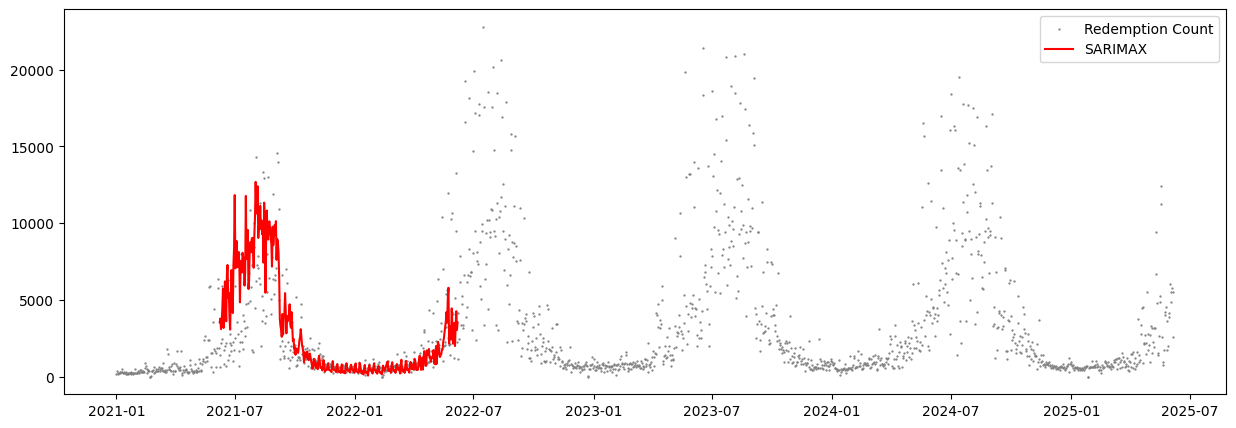

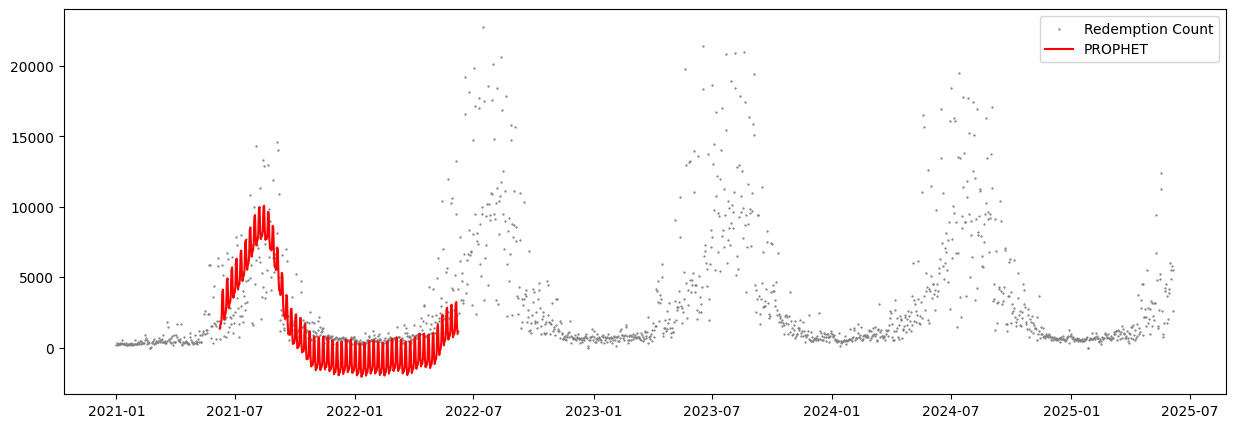

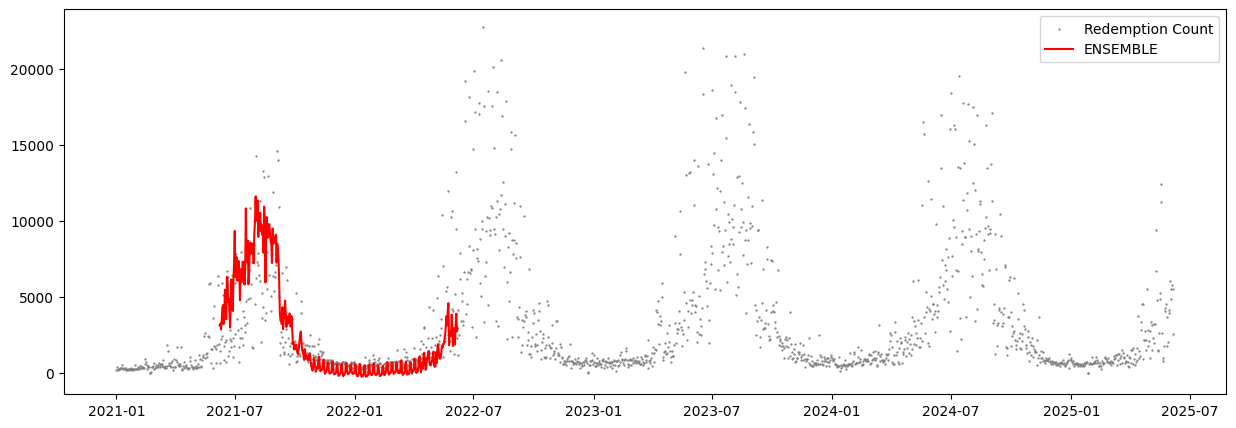

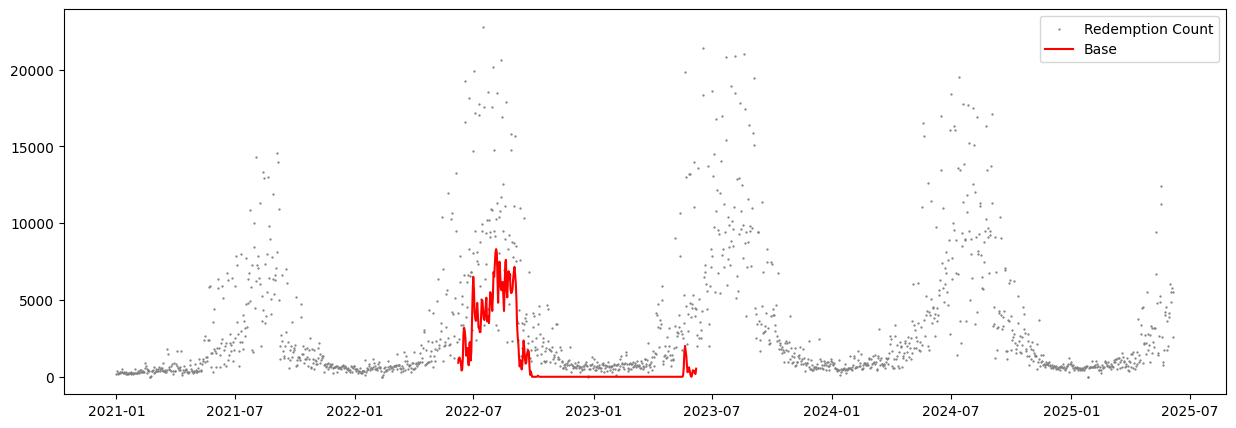

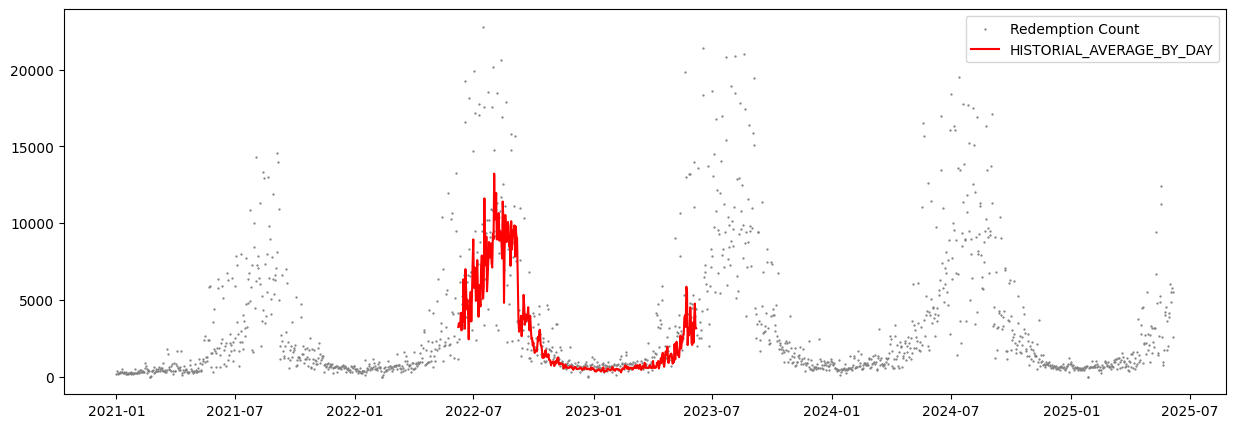

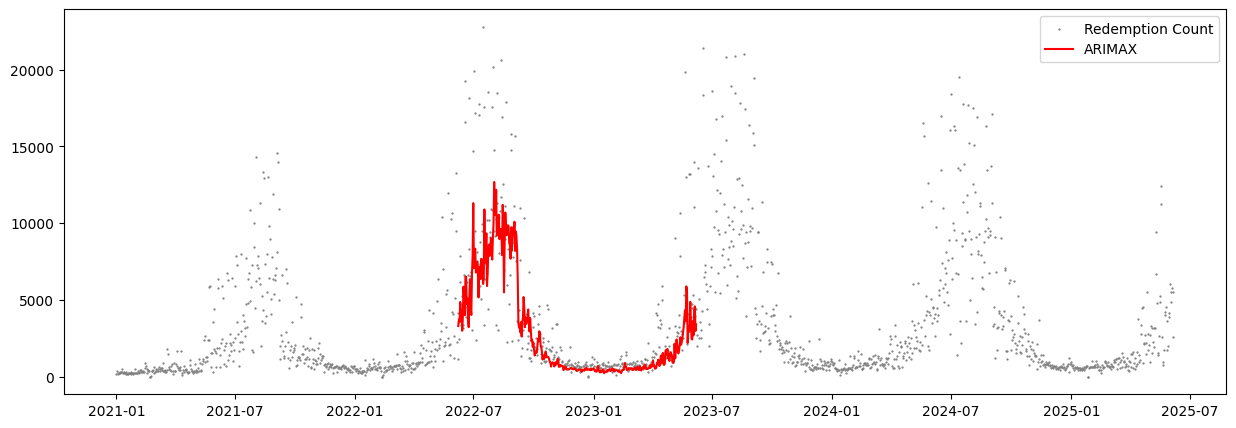

/Users/marianomaisonnave/Repositories/COMP-44081/.venv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


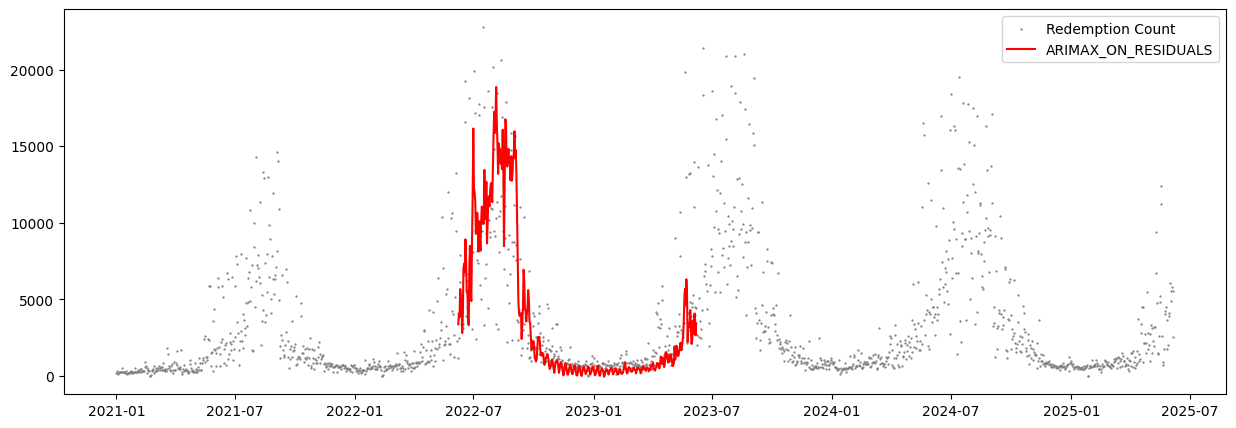

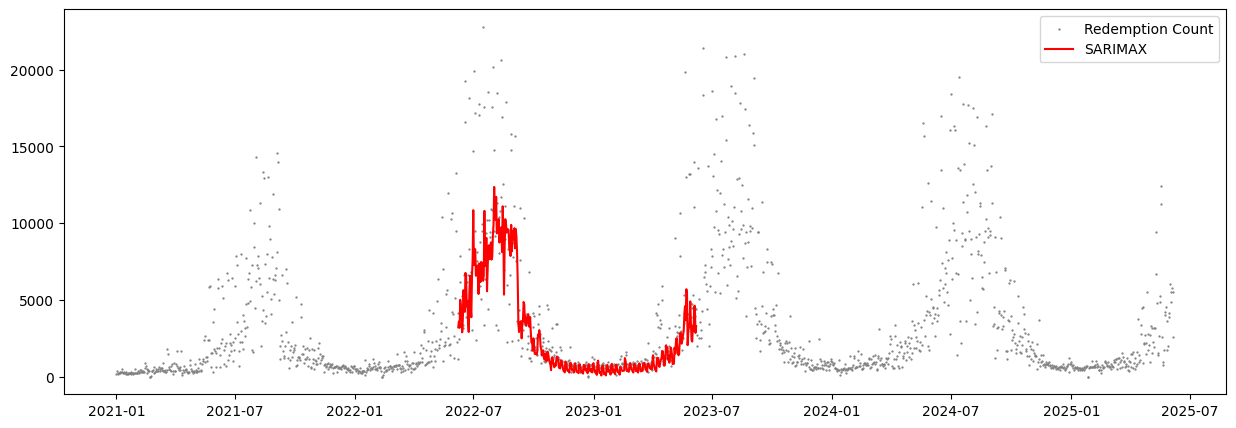

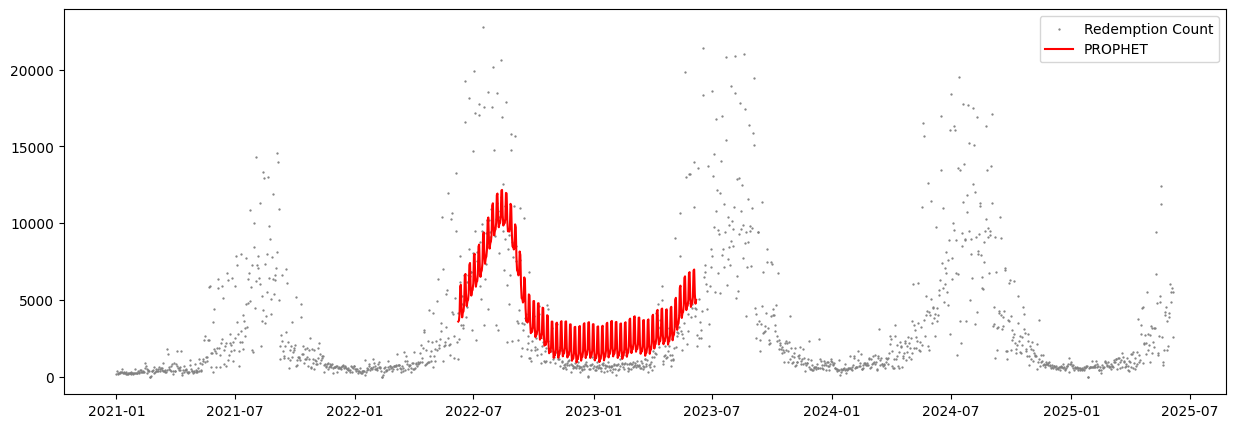

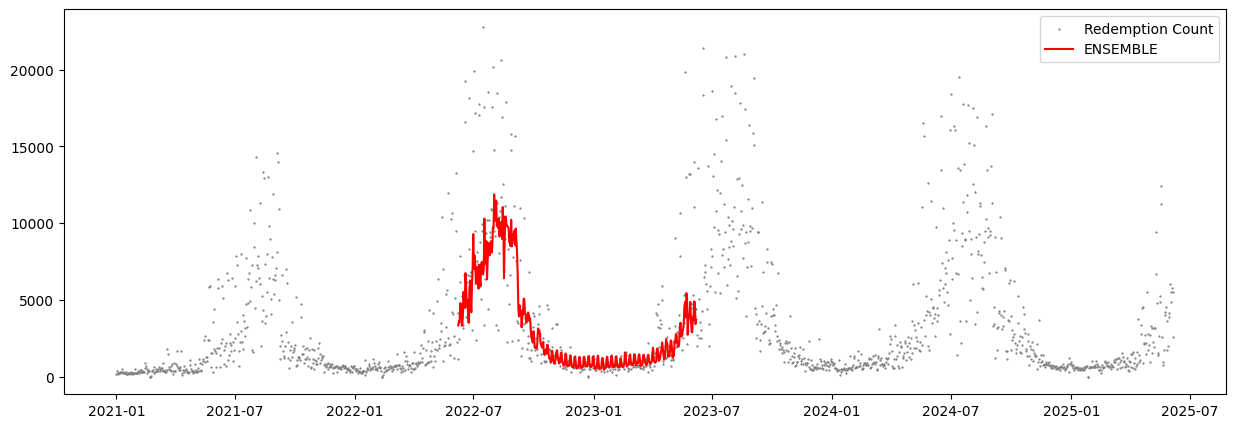

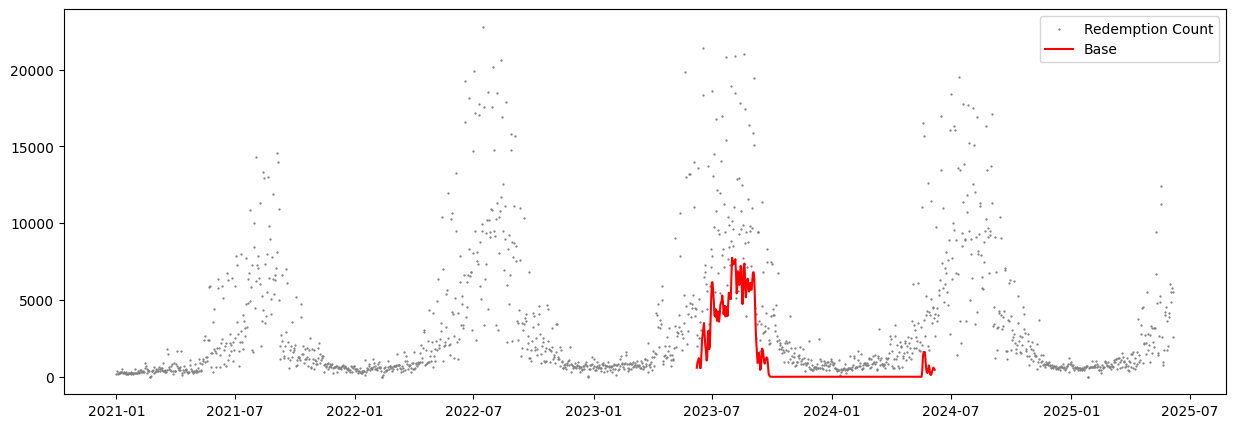

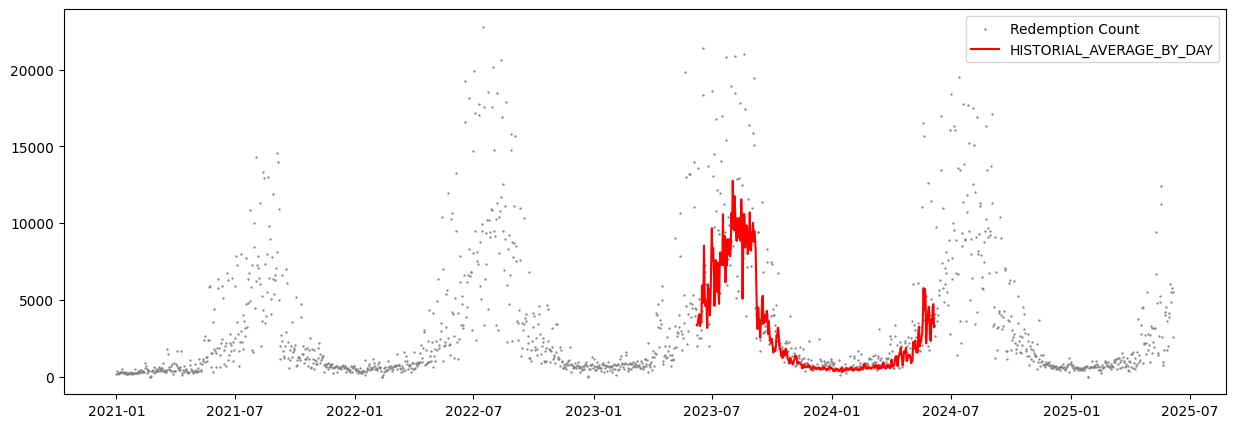

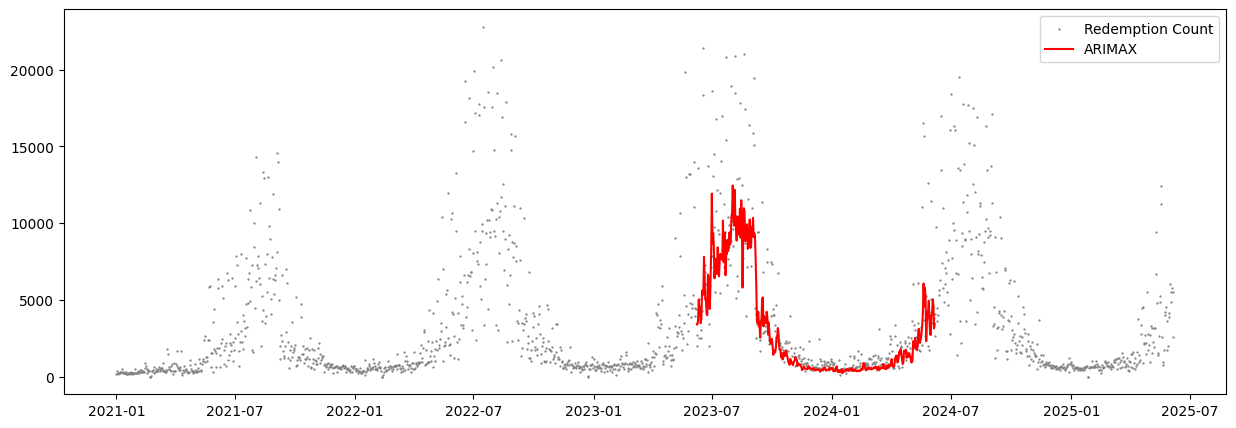

/Users/marianomaisonnave/Repositories/COMP-44081/.venv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


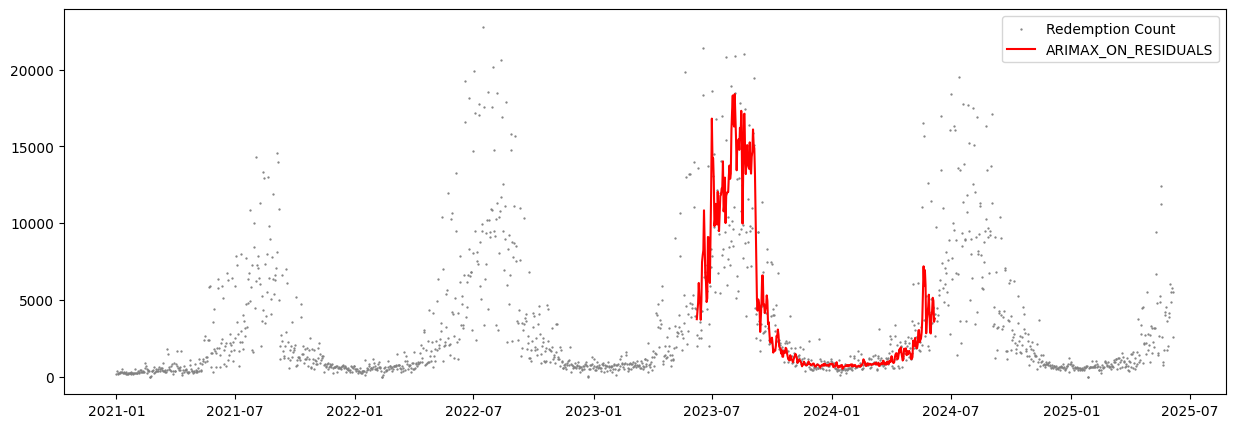

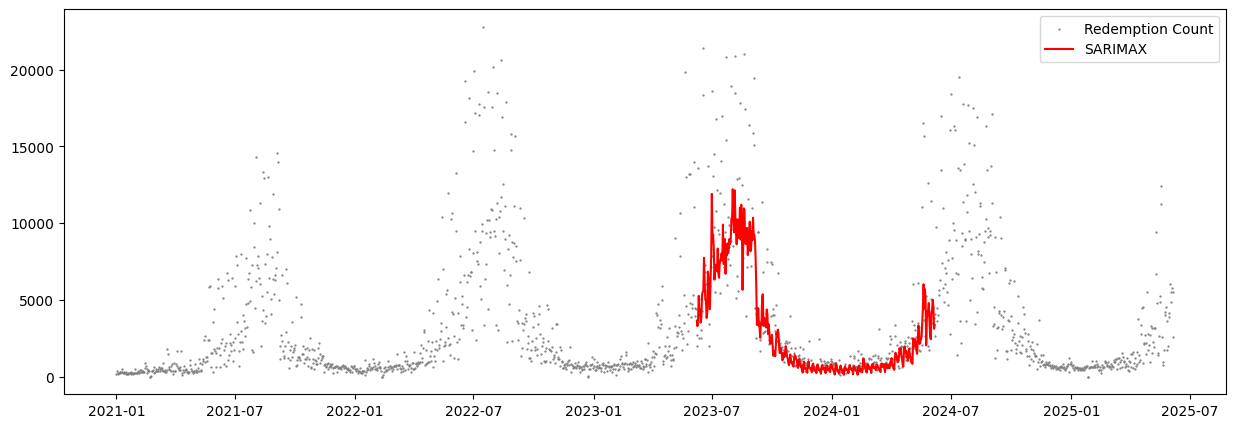

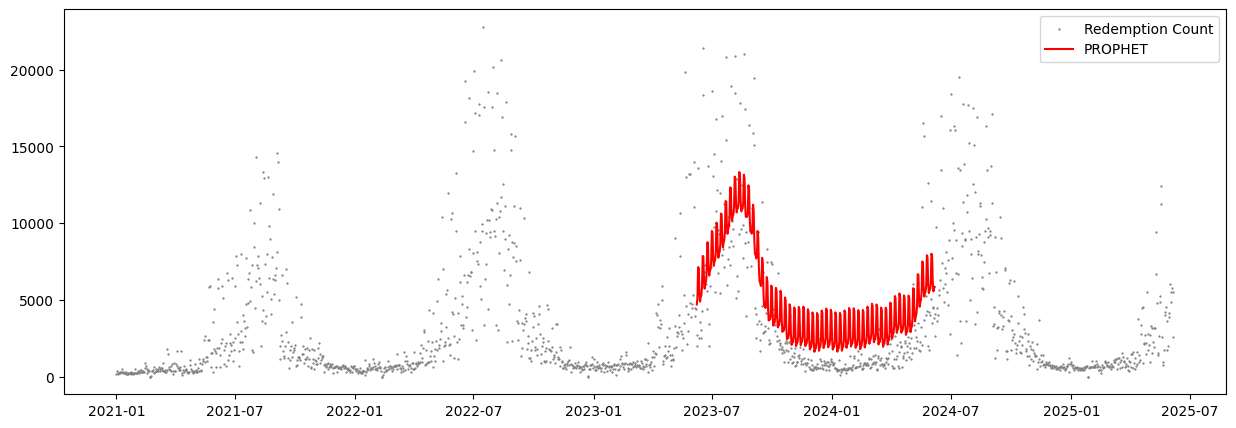

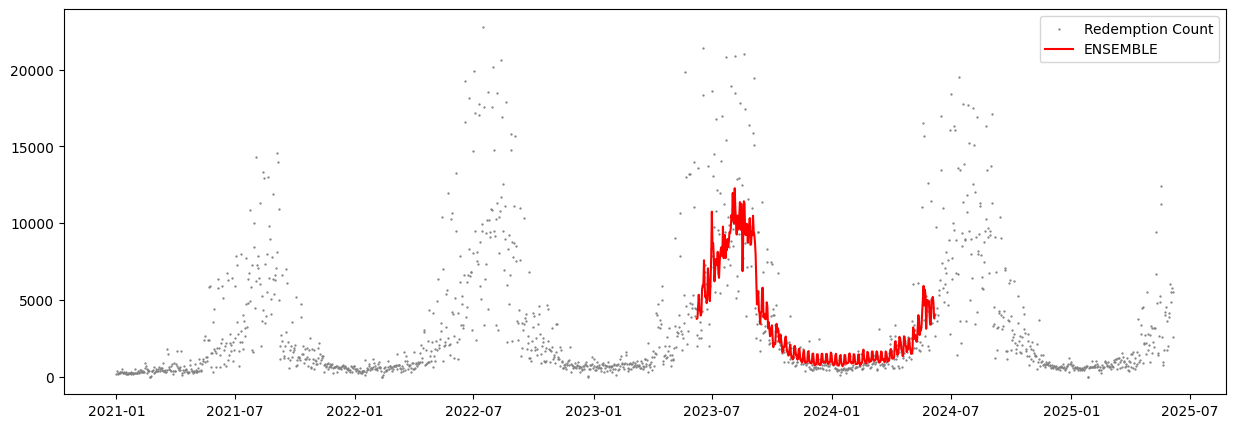

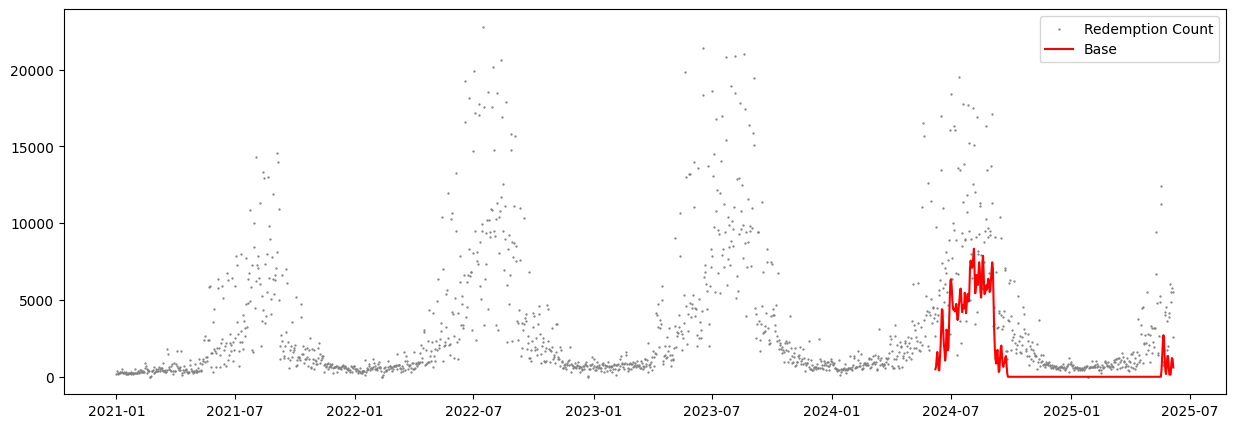

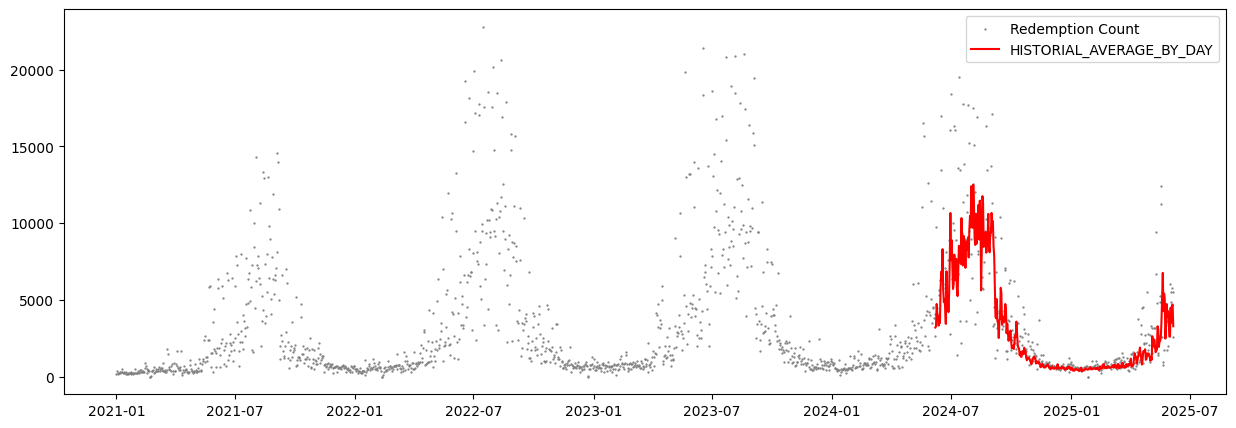

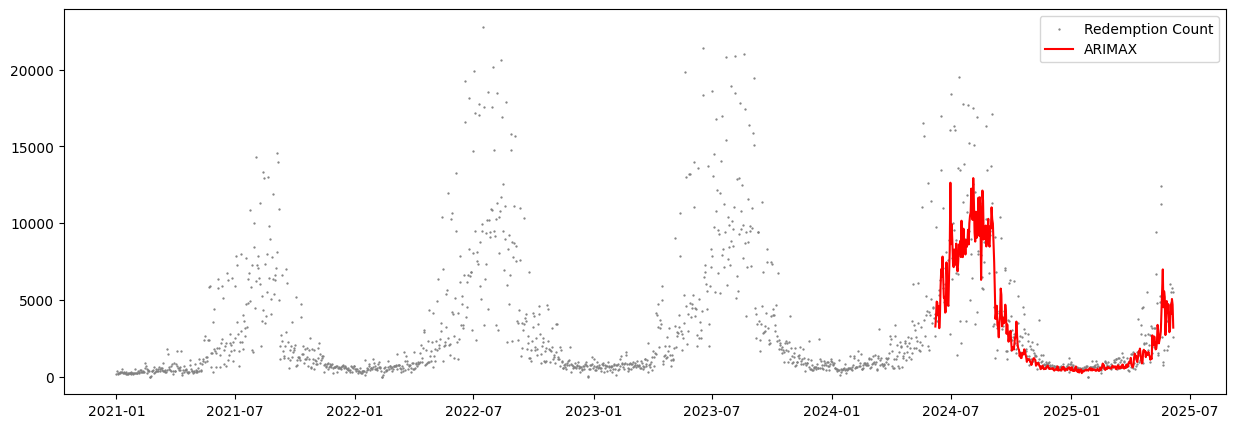

/Users/marianomaisonnave/Repositories/COMP-44081/.venv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


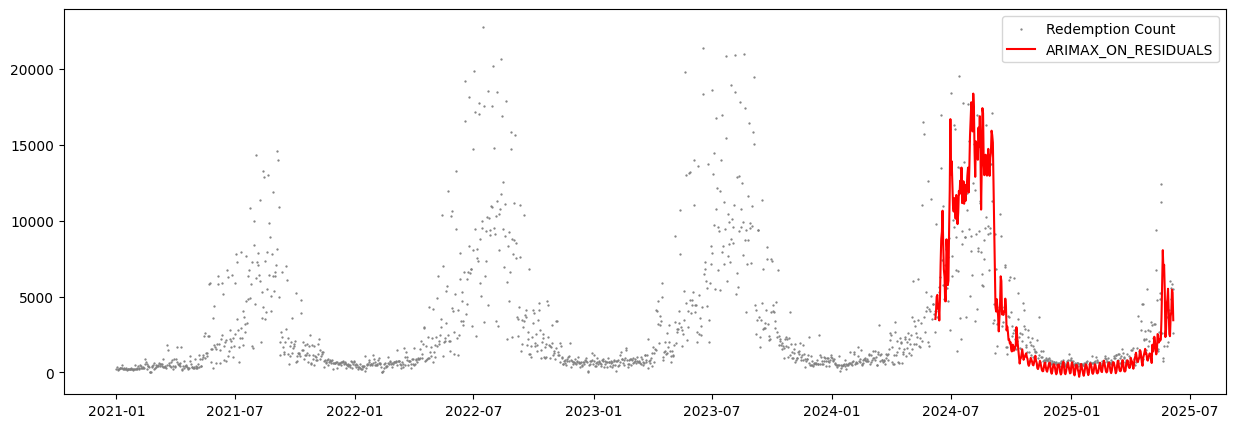

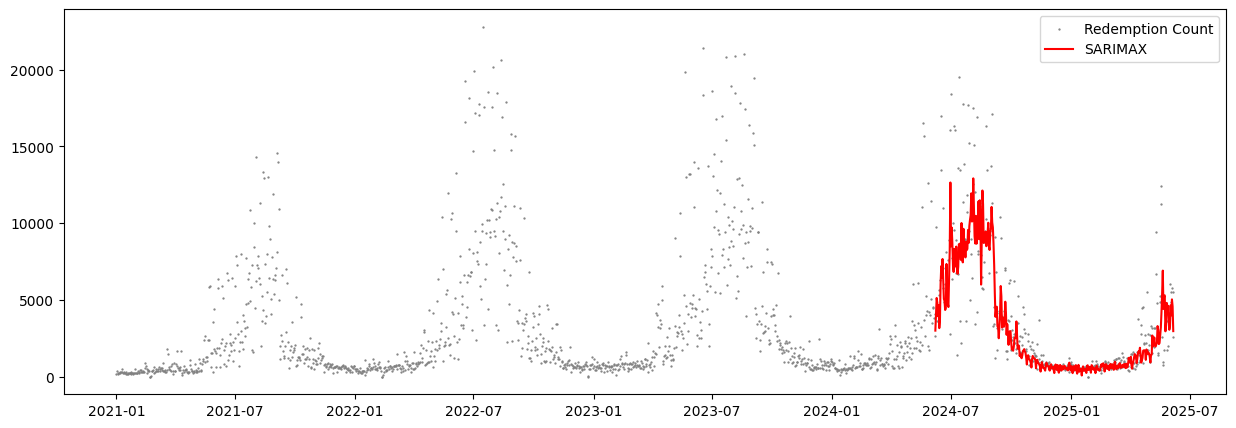

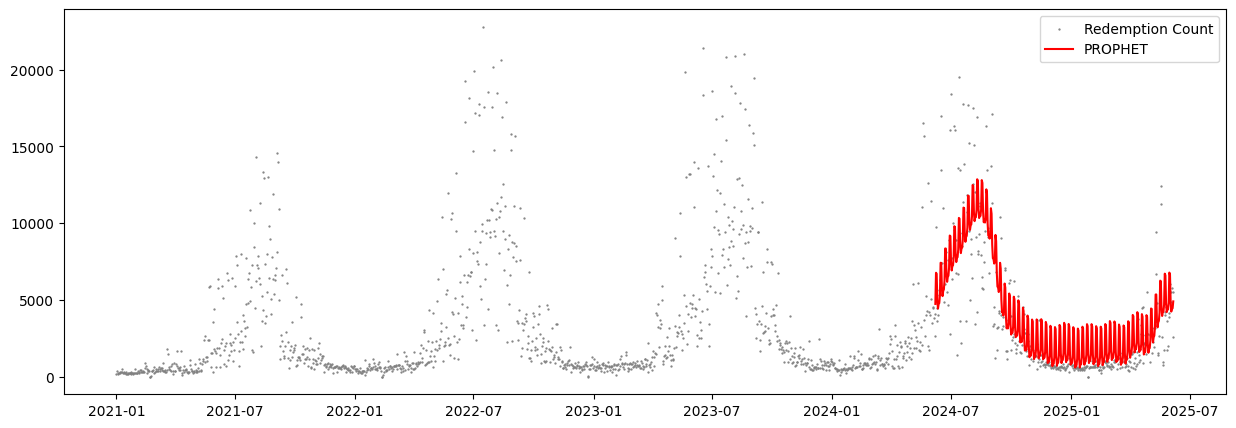

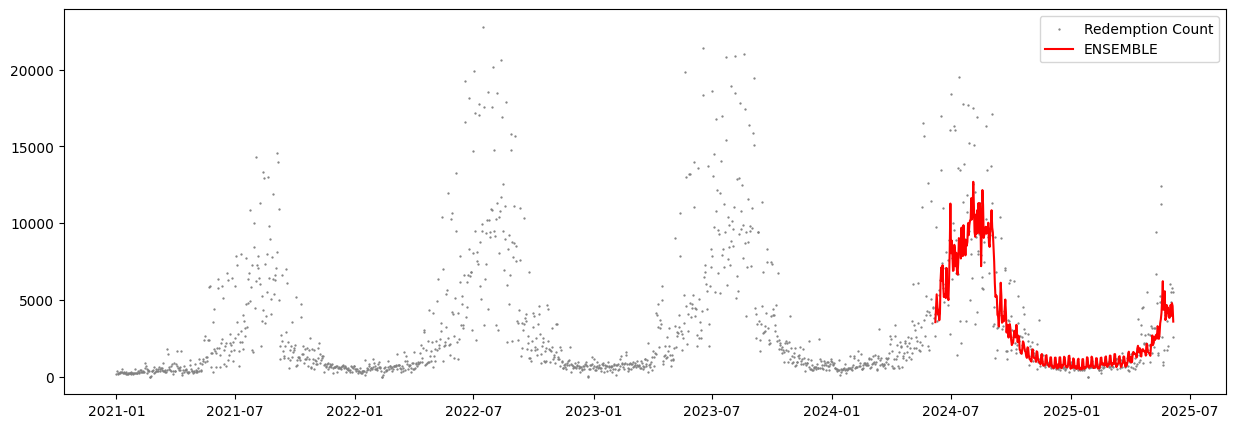

In [4]:
experiment_configuration = {
    'MODELS_TO_RUN': {
        'HISTORIAL_AVERAGE_BY_DAY', 
        'ARIMAX', 
        'ARIMAX_ON_RESIDUALS', 
        'SARIMAX', 
        'PROPHET', 
        'ENSEMBLE'
        },

    'ARIMAX': {'p': 8, 'd': 0, 'q': 0, 'exog_cols': ['Sales Count']},

    'ARIMAX_ON_RESIDUALS': {'p': 5, 'd': 1, 'q': 7,
                'exog_cols': ['Sales Count']},


    'SARIMAX': {'p': 1, 'd': 0, 'q': 0, 
                'P': 1, 'D': 1, 'Q': 1, 's': 7,
                'exog_cols': ['Sales Count']},


    'PROPHET': {
        'yearly_seasonality': True, 
        'daily_seasonality': False, 
        'weekly_seasonality': True
    },

    'ENSEMBLE': {'included-models': [
        # 'ARIMAX_ON_RESIDUALS', 
        'ARIMAX', 
        'SARIMAX',
        'HISTORIAL_AVERAGE_BY_DAY',
        'PROPHET',
        ],}
}
redemption_model = Model(df, 
           target_col='Redemption Count', 
           experiment_configuration=experiment_configuration,
           )
redemption_model.run_models()

In [5]:
import json


def average_performance(results):
    for model, splits in results.items():
        metrics = list(next(iter(splits.values())).keys())
        avg_metrics = {metric: 0 for metric in metrics}
        for split in splits.values():
            for metric in metrics:
                avg_metrics[metric] += split[metric]
        for metric in metrics:
            avg_metrics[metric] /= len(splits)
        print(f"Model '{model}':")
        for metric, avg in avg_metrics.items():
            print(f"  {metric:4}: {avg:16,.4f}")
        print()

average_performance(redemption_model.results)

# Save result to JSON   
with open('results_redemption_forecasting.json', 'w') as f:
    json.dump(redemption_model.results, f, indent=4, default=str)

Model 'Base':
  MAPE:           0.8652
  MAE :       2,468.6425
  MSE :  14,659,607.3346

Model 'HISTORIAL_AVERAGE_BY_DAY':
  MAPE:           0.4769
  MAE :       1,595.0007
  MSE :   8,527,879.6253

Model 'ARIMAX':
  MAPE:           0.4919
  MAE :       1,564.0815
  MSE :   7,978,916.7322

Model 'ARIMAX_ON_RESIDUALS':
  MAPE:           0.6523
  MAE :       1,919.3473
  MSE :  10,771,477.8212

Model 'SARIMAX':
  MAPE:           0.5154
  MAE :       1,548.4130
  MSE :   7,700,801.6993

Model 'PROPHET':
  MAPE:           1.4159
  MAE :       1,946.4466
  MSE :   7,174,836.9370

Model 'ENSEMBLE':
  MAPE:           0.5915
  MAE :       1,496.7781
  MSE :   7,054,470.3959

